In [1]:
import os
import numpy as np
import torch
import pandas as pd
from sklearn import metrics
import multiprocessing as mp
from GARDEN import GARDEN
import scanpy as sc
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
os.environ['R_HOME'] = "/home/zhangxinming/anaconda3/envs/Test/lib/R"

/home/zhangxinming/anaconda3/envs/Test/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read('adata_peaks_normalized.h5ad')
adata

AnnData object with n_obs × n_vars = 9215 × 121068
    obs: 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_peaks', 'nFeature_peaks', 'RNA_clusters', 'ATAC_clusters'
    var: 'count', 'percentile'
    uns: 'ATAC', 'ATAC_clusters_colors', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_umap', 'spatial'
    obsp: 'ATAC_connectivities', 'ATAC_distances'

In [3]:
from GARDEN.ATAC_preprocess import lsi
lsi(adata, use_highly_variable=False, n_components=201)
print(adata.obsm['feat'].shape)

/home/zhangxinming/anaconda3/envs/Test/lib/python3.8/site-packages/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


X_lsi is in adata.obsm['feat'] !
(9215, 200)


In [4]:
from GARDEN.preprocess import permutation
adata.obsm['feat_a'] = permutation(adata.obsm['feat'])

In [ ]:
model = GARDEN.GARDEN(adata,k_dynamic=6,device=device,k_cl=7,model_select = 'KNN')
# train model
adata = model.train()

/home/zhangxinming/anaconda3/envs/Test/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


The graph contains 55290 edges, 9215 cells.
6.0000 neighbors per cell on average.
Graph_2 Construction
The graph contains 55290 edges, 9215 cells.
6.0000 neighbors per cell on average.
Begin to train ST data...


  0%|          | 1/800 [00:00<05:49,  2.29it/s]

Overall loss : tensor(30.5848, device='cuda:3', grad_fn=<AddBackward0>)


 14%|█▎        | 108/800 [00:03<00:16, 40.90it/s]

Overall loss : tensor(15.3152, device='cuda:3', grad_fn=<AddBackward0>)


 26%|██▌       | 208/800 [00:05<00:14, 40.31it/s]

Overall loss : tensor(14.6453, device='cuda:3', grad_fn=<AddBackward0>)


 38%|███▊      | 308/800 [00:07<00:12, 40.98it/s]

Overall loss : tensor(14.2723, device='cuda:3', grad_fn=<AddBackward0>)


 51%|█████     | 408/800 [00:10<00:09, 40.88it/s]

Overall loss : tensor(13.4331, device='cuda:3', grad_fn=<AddBackward0>)


 64%|██████▎   | 508/800 [00:12<00:07, 40.91it/s]

Overall loss : tensor(12.2216, device='cuda:3', grad_fn=<AddBackward0>)


 76%|███████▌  | 608/800 [00:15<00:04, 40.75it/s]

Overall loss : tensor(11.5012, device='cuda:3', grad_fn=<AddBackward0>)


 88%|████████▊ | 708/800 [00:17<00:02, 40.72it/s]

Overall loss : tensor(11.2323, device='cuda:3', grad_fn=<AddBackward0>)


100%|██████████| 800/800 [00:19<00:00, 40.04it/s]


Optimization finished for ST data!


In [6]:
# set radius to specify the number of neighbors considered during refinement
radius = 10
tool = 'mclust' # mclust, leiden, and louvain
n_clusters = 18
# clustering
from GARDEN.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters=18, radius=radius, method=tool, refinement=False) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=1.3, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


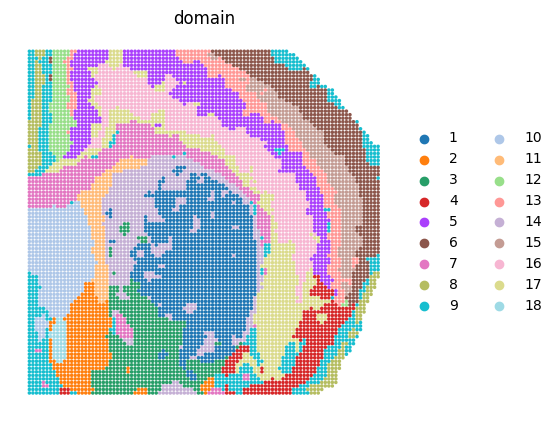

In [7]:
import matplotlib.pyplot as plt
adata.obsm['spatial'][:,1] = -1*adata.obsm['spatial'][:,1]
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.spatial(adata,color = 'domain',frameon = False,colorbar_loc=None,spot_size=1)